## Task: Classify images 0 or 1

### Description



* Input: 28x28 (batched) arrays of pixel data
* pixel data: 0-255 (intensity)
* Output: 0 or 1 for each image in batch
* Goal: best accuracy (% correctly identified)

**Question:** how is this different than other programming tasks?

### Tools

#### matplotlib
* information-visualization suite
* [Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet) - an allegory on data visualization

In [1]:
import matplotlib.pyplot as plt # "plt" is a standard alias

#### numpy
* used for handling mutli-dimensional arrays
* ~100x more efficient than pure python

In [2]:
import numpy as np # "np" is a standard alias

* here is some format settings...

In [3]:
np.set_printoptions(
    linewidth=180,
    edgeitems=16,
    formatter={
        "float": lambda x: f"{x:6.3f}",
    },
)

#### pandas
* useful for import/export of data

In [4]:
import pandas as pd # "pd" is a standard alias

### Data

#### Overview

* We have at our disposal a dataset with sample images and labels indicating if they are a 1 or 0
* We can use this data to test the accuracy of our model
* When our model is truly evaluated, it will be evaluated against a dataset we have never seen before.

#### Import

In [5]:
data_file_name = 'archive/mnist_train.csv'

image_data_frame = pd.read_csv(data_file_name)
image_data_frame

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Filtering and "Shaping"

In [6]:
labels = [0,1]
image_and_label_data = image_data_frame[image_data_frame.label.isin(labels)].to_numpy()
image_data = image_and_label_data[:,1:].reshape((-1,28,28))
label_data = image_and_label_data[:,0].reshape((-1))

## Implementation

I'm curious about the data.  Let's look at it.

### Data Visualization

#### Most straightforward way of viewing an image from the dataset

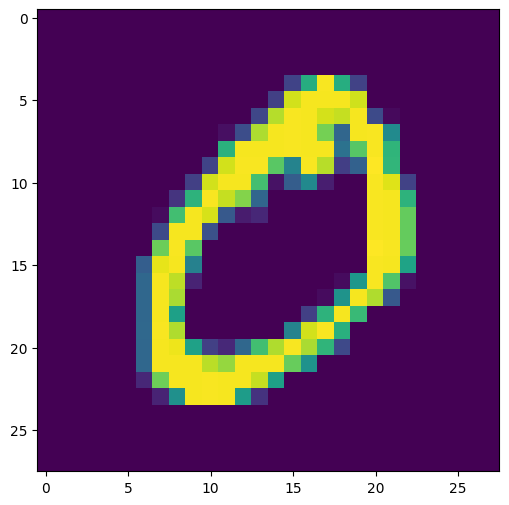

In [7]:
plt.rcParams['figure.figsize'] = 6,6
# Look at the first image
plt.imshow(image_data[0])

#### More sophisticated way of viewing images in dataset...

In [8]:
def show_images(image_data, columns=3, rows=None, titles=None):
    rows = rows or image_data.shape[0] // columns
    titles = titles if titles is not None else list(range(rows*columns))
    fig, axes = plt.subplots(rows, columns, figsize=(6,6))

    for image_datum,ax,i in zip(image_data, axes.flat, range(rows*columns)):
        ax.imshow(image_datum)
        ax.set_title(titles[i])
    fig.tight_layout()
    return fig, axes


In [9]:
rng = np.random.default_rng()
default_titles = np.array([f'i:{i}, l:{label_data[i]}' for i in range(image_data.shape[0])])

def show_random_sample(titles=None):
    n = 9
    index = rng.integers(0, image_data.shape[0], n)
    show_images(image_data[index], rows=3, titles=default_titles[index] if titles is None else titles[index])

#### Random Sample of images

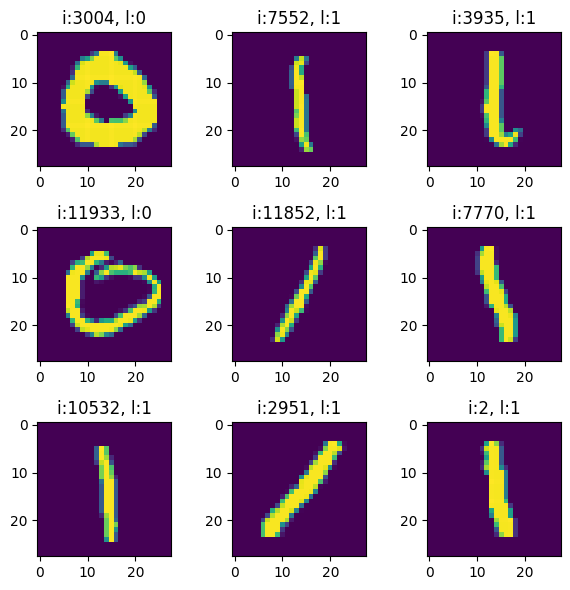

In [10]:
show_random_sample()

* How can we tell apart 0s and 1s?

### First Idea

In [11]:
def total_active_cells(image_data):
    """(-1,28,28) -> (-1) : counts total pixels with non-zero intensity"""
    return np.sum(image_data.clip(min=0,max=1), axis=(1,2))

total_active_cells_feature = total_active_cells(image_data)

#### Visualizing the feature

First, we can see its values for some images

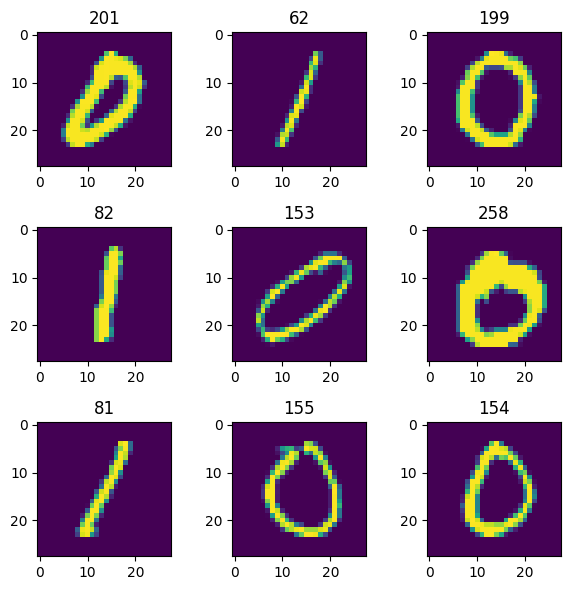

In [12]:
show_random_sample(titles=total_active_cells_feature)

We need a more "global" view of the feature

(array([ 3.000, 29.000, 65.000, 177.000, 476.000, 698.000, 788.000, 733.000, 823.000, 703.000, 659.000, 487.000, 352.000, 269.000, 148.000, 99.000, 76.000, 63.000, 31.000, 23.000,
        20.000,  9.000,  4.000,  2.000,  1.000,  1.000,  0.000,  1.000,  1.000,  1.000]),
 array([34.000, 39.867, 45.733, 51.600, 57.467, 63.333, 69.200, 75.067, 80.933, 86.800, 92.667, 98.533, 104.400, 110.267, 116.133, 122.000, 127.867, 133.733, 139.600, 145.467,
        151.333, 157.200, 163.067, 168.933, 174.800, 180.667, 186.533, 192.400, 198.267, 204.133, 210.000]),
 <BarContainer object of 30 artists>)

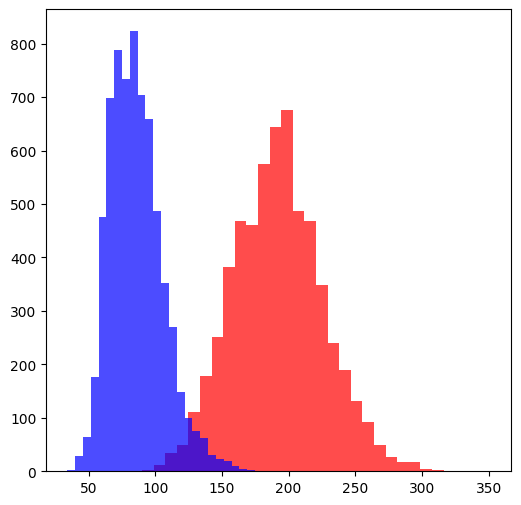

In [13]:
plt.rcParams['figure.figsize'] = 6,6
alpha=.7
bins=30
plt.hist(total_active_cells_feature[label_data == 0], bins=bins, alpha=alpha, color='red', label='0')
plt.hist(total_active_cells_feature[label_data == 1], bins=bins, alpha=alpha, color='blue', label='1')

#### First Attempt

In [14]:
# implement

## Optimized Implementations

#### Typing

* python allows for "type-hints" that can be integrated into best practices
* **Can be ignored**
* not recommended for unexperienced programmers (prefer good comments)

In [15]:
import typing as T

### Metrics

In [16]:
def batch_accuracy(batch_predictions: np.ndarray, truth: np.ndarray) -> np.ndarray:
    """(m,n), (n) -> (m)"""
    return (batch_predictions == truth.reshape((1,-1))).mean(axis=1)

### Grid Search

#### grid_search_binary_classifier

In [17]:
from dataclasses import dataclass

@dataclass
class GridSearchResult:
    optimal_parameter_index: int
    optimal_parameter: float
    best_accuracy: float
    search_history: np.ndarray


def grid_search_binary_classifier(
    kernel: np.ndarray,
    image_data: np.ndarray,
    label_data: np.ndarray,
    labels: T.Tuple[int, int],
    n = 128,
) -> GridSearchResult:
    """(28,28), (-1,28,28), (-1) -> best_parameter, best_accuracy, search_results"""
    features = (kernel.reshape((1, 28, 28)) * image_data.clip(min=0, max=1)).sum(axis=(1, 2))
    f0 = features[label_data == labels[0]]
    f1 = features[label_data == labels[1]]
    f0_max = f0.max()
    f1_min = f1.min()
    if f0_max < f1_min:
        optimal_parameter_index = 0
        optimal_parameter = (f0_max + f1_min) / 2
        best_accuracy = 1.0
        search_history = np.array([optimal_parameter, accuracy]).reshape((-1,2))
        return optimal_parameter, 
    else:
        parameters = np.linspace(f1_min, f0_max, n)
        predictions = np.where(features.reshape((1,-1)) < parameters.reshape((-1,1)), labels[0], labels[1])
        # rows are for parameters, columns are predictions for images
        assert predictions.shape == ((parameters.shape[0], image_data.shape[0]))
        accuracy = batch_accuracy(predictions, label_data)

        optimal_parameter_index = np.argmax(accuracy)
        optimal_parameter = parameters[optimal_parameter_index]
        best_accuracy = accuracy[optimal_parameter_index]
        search_history = np.hstack([parameters.reshape((-1,1)), accuracy.reshape((-1,1))])
        
    return GridSearchResult(
        optimal_parameter_index=optimal_parameter_index,
        optimal_parameter=optimal_parameter,
        best_accuracy=best_accuracy,
        search_history=search_history,
    )


#### Viewing GridSearchResult

In [18]:
def show_grid_search_result(grid_search_result: GridSearchResult):
    fig, ax = plt.subplots(figsize=(4,4))
    history = grid_search_result.search_history
    ax.scatter(history[:,0], history[:,1], marker='s', s=1)
    ax.vlines(grid_search_result.optimal_parameter, history[:,1].min(), 1.0)
    ax.set_title(f'optimal_param:{grid_search_result.optimal_parameter:8.3f}, best_accuracy: {grid_search_result.best_accuracy:6.4f}')
    return fig, ax

(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot: title={'center': 'optimal_param: 131.412, best_accuracy: 0.9722'}>)

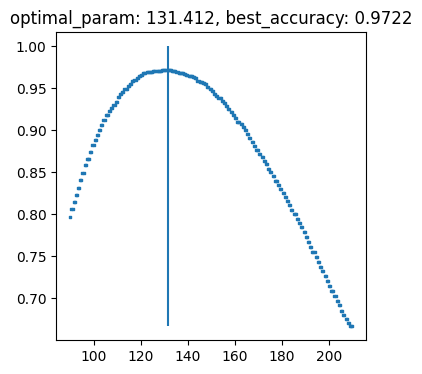

In [19]:
grid_search_result = grid_search_binary_classifier(np.ones((28,28)), image_data, label_data, labels=[1,0], n=256)
show_grid_search_result(grid_search_result)
# grid_search_result

### Kernels

#### Basis

In [20]:
def make_rectangular_partition(
    a: np.ndarray,
    rows: T.List[int],
    columns: T.List[int],
) -> np.ndarray:
    """(max(rows), max(columns)), ..., -> (len(rows)-1 * len(columns)-1, a.shape)"""
    partition = []
    for i in range(len(rows) - 1):
        for j in range(len(columns) - 1):
            z = np.zeros(a.shape)
            a_values = a[rows[i] : rows[i + 1], columns[j] : columns[j + 1]]
            z[rows[i] : rows[i + 1], columns[j] : columns[j + 1]] = a_values
            partition.append(z)
    return np.stack(partition)


make_rectangular_partition(np.ones((4, 4)), [0, 3, 4], [0, 2, 4])


array([[[ 1.000,  1.000,  0.000,  0.000],
        [ 1.000,  1.000,  0.000,  0.000],
        [ 1.000,  1.000,  0.000,  0.000],
        [ 0.000,  0.000,  0.000,  0.000]],

       [[ 0.000,  0.000,  1.000,  1.000],
        [ 0.000,  0.000,  1.000,  1.000],
        [ 0.000,  0.000,  1.000,  1.000],
        [ 0.000,  0.000,  0.000,  0.000]],

       [[ 0.000,  0.000,  0.000,  0.000],
        [ 0.000,  0.000,  0.000,  0.000],
        [ 0.000,  0.000,  0.000,  0.000],
        [ 1.000,  1.000,  0.000,  0.000]],

       [[ 0.000,  0.000,  0.000,  0.000],
        [ 0.000,  0.000,  0.000,  0.000],
        [ 0.000,  0.000,  0.000,  0.000],
        [ 0.000,  0.000,  1.000,  1.000]]])

In [21]:
def make_basis(rows: T.List[int], columns: T.List[int]) -> np.ndarray:
    return make_rectangular_partition(np.ones((max(rows), max(columns))), rows, columns)


#### Kernel Scores

In [22]:
def overlap_score(kernels: np.ndarray, image_data: np.ndarray, label_data: np.ndarray, labels: T.List[int]) -> np.ndarray:
    """(m,28,28), (n,28,28), (n) -> (m) : calculates 'feature overlap'"""
    features = (np.expand_dims(kernels, 1) * np.expand_dims(image_data.clip(min=0,max=1), 0)).sum(axis=(2, 3))

    f0 = features[:, label_data == labels[0]]
    f1 = features[:, label_data == labels[1]]
    f0_max = f0.max(axis=1).reshape((-1, 1))
    f1_min = f1.min(axis=1).reshape((-1, 1))
    assert f0_max.shape[0] == kernels.shape[0]
    assert f1_min.shape[0] == kernels.shape[0]

    return (f0 > f1_min).sum(axis=1) + (f1 < f0_max).sum(axis=1)


In [23]:
def cosine_score(kernels: np.ndarray, image_data: np.ndarray, label_data: np.ndarray, labels: T.List[int]) -> np.ndarray:
    """(m,28,28), (n,28,28), (n) -> (m) : calculates 'feature overlap'"""
    features = (np.expand_dims(kernels, 1) * np.expand_dims(image_data.clip(min=0, max=1), 0)).sum(axis=(2, 3)) / (
        np.linalg.norm(np.expand_dims(kernels, 1), axis=(2, 3))
        * np.linalg.norm(np.expand_dims(image_data.clip(min=0, max=1), 0), axis=(2, 3))
    )
    f0 = features[:, label_data == labels[0]]
    f1 = features[:, label_data == labels[1]]
    f0_max = f0.max(axis=1).reshape((-1, 1))
    f1_min = f1.min(axis=1).reshape((-1, 1))
    assert f0_max.shape[0] == kernels.shape[0]
    assert f1_min.shape[0] == kernels.shape[0]

    # return f0.mean(axis=1) - f1.mean(axis=1)
    return (f0 > f1_min).sum(axis=1) + (f1 < f0_max).sum(axis=1)


#### LinearBasisKernel

In [24]:
class LinearBasisKernel:
    def __init__(self, basis: np.ndarray, coefficients: np.ndarray):
        self.basis = basis
        self.coefficients = coefficients

    @classmethod
    def get_kernels(cls, basis: np.ndarray, batch_coefficients: np.ndarray) -> np.ndarray:
        """(n,28,28), (m,n) -> (m,28,28)"""
        return (basis.reshape((1, *basis.shape)) * batch_coefficients.reshape((-1, basis.shape[0], 1, 1))).sum(axis=(1))
    
    def get_kernel(self):
        return (self.coefficients.reshape((-1,1,1))*self.basis).sum(axis=0)
    
    def fit(self, image_data: np.ndarray, label_data: np.ndarray, labels: T.List[int], c_min=0, c_max=2, n=64, score=overlap_score) -> np.ndarray:
        """(n,28,28), (n) -> [...coefficients,score]"""
        basis_shape = self.basis.shape
        c_size = basis_shape[0]

        def yield_coefficients():
            """Running the operation for n > 32 can result in drastic slowdown"""
            coefficients = rng.integers(c_min, c_max + 1, n * c_size).reshape((n, c_size))
            i = 0
            speed = 4
            while i < n:
                yield coefficients[i : i + speed]
                i += speed

        scores_list = []
        coefficients_list = []
        for coefficients in yield_coefficients():
            coefficients_list.append(coefficients)
            kernels = self.get_kernels(self.basis, coefficients)
            assert kernels.shape[1:] == basis_shape[1:]
            scores_list.append(score(kernels, image_data, label_data, labels))

        scores = np.hstack(scores_list)
        coefficients = np.vstack(coefficients_list)
        index = np.argsort(scores)

        non_zero_index = index[scores[index] > 0]
        result = np.hstack([coefficients[non_zero_index], scores[non_zero_index].reshape((-1, 1))])
        self.coefficients = result[0, :-1]
        return result


# LinearBasisKernel.get_kernels(make_basis([0, 3, 4], [0, 2, 4]), rng.integers(0, 2, 4 * 6).reshape((6, 4)))
lk = LinearBasisKernel(make_basis([0, 14, 28], [0, 28]), np.ones(2))
lk_training_results = lk.fit(image_data, label_data, [1, 0], n=8)
lk.coefficients


array([0, 1], dtype=int64)

## Final Pipeline

In [25]:
class FittedKernelBinaryClassifier:
    def __init__(
        self,
        basis: np.ndarray,
        labels: T.List[int],
        coefficients: np.ndarray = None,
        threshold: float = 0.0,
        kernel_score=overlap_score,
    ):
        self.linear_basis_kernel = LinearBasisKernel(basis, coefficients if coefficients is not None else np.ones(basis.shape[0]))
        self.threshold = threshold
        self.labels = labels
        self.kernel_score = kernel_score

    def predict(self, X: np.ndarray) -> np.ndarray:
        features = (self.linear_basis_kernel.get_kernel().reshape(1,28,28) * X.clip(min=0, max=1)).sum(axis=(1, 2))
        assert features.shape == (X.shape[0],)
        return np.where(features < self.threshold, self.labels[0], self.labels[1])

    def fit(self, X: np.ndarray, y: np.ndarray, topk=32):
        kernel_results = self.linear_basis_kernel.fit(X, y, self.labels, c_min=0, c_max=2, n=512, score=self.kernel_score)
        _scores = []
        grid_search_results: T.List[GridSearchResult] = []
        _best_score = -1
        _best_score_arg = -1
        for i in range(topk):
            self.linear_basis_kernel.coefficients = kernel_results[i, :-1]
            kernel = self.linear_basis_kernel.get_kernel()
            grid_search_result = grid_search_binary_classifier(kernel, image_data, label_data, self.labels, n=256)
            if _best_score == -1 or grid_search_result.best_accuracy > _best_score:
                _best_score = grid_search_result.best_accuracy
                _best_score_arg = i
            grid_search_results.append(grid_search_result)
        self.linear_basis_kernel.coefficients = kernel_results[_best_score_arg, :-1]
        self.threshold = grid_search_results[_best_score_arg].optimal_parameter
        return kernel_results, grid_search_results

    def score(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        return (self.predict(X) == y).mean()


model = FittedKernelBinaryClassifier(make_basis([0, 7, 14, 21, 28], [0, 10, 18, 28]), labels=[1, 0], kernel_score=cosine_score)
kernel_results, grid_search_results = model.fit(image_data, label_data)
model.score(image_data, label_data)


0.9912356889064351

In [26]:
model.score(image_data, label_data), [(g.optimal_parameter, g.best_accuracy) for g in grid_search_results[:16]]

(0.9912356889064351,
 [(147.0078431372549, 0.9887879984208449),
  (175.1764705882353, 0.9897354915120411),
  (110.20392156862745, 0.9908409001184366),
  (112.01176470588234, 0.9857086458744572),
  (99.34901960784313, 0.9907619423608369),
  (98.16470588235293, 0.9912356889064351),
  (180.21568627450978, 0.9825503355704698),
  (125.52941176470588, 0.9832609553888669),
  (128.35294117647058, 0.9819186735096723),
  (152.23921568627452, 0.9858665613896566),
  (111.23529411764706, 0.986024476904856),
  (117.28627450980392, 0.9836557441768654),
  (154.30588235294118, 0.9844453217528623),
  (87.07843137254902, 0.9892617449664429),
  (98.27058823529413, 0.9808922226608764),
  (73.15294117647059, 0.9767864192656929)])

(<Figure size 800x1600 with 16 Axes>,
 array([[<AxesSubplot: title={'center': 'acc:  0.989'}>, <AxesSubplot: title={'center': '2117'}>],
        [<AxesSubplot: title={'center': 'acc:  0.990'}>, <AxesSubplot: title={'center': '2526'}>],
        [<AxesSubplot: title={'center': 'acc:  0.991'}>, <AxesSubplot: title={'center': '2539'}>],
        [<AxesSubplot: title={'center': 'acc:  0.986'}>, <AxesSubplot: title={'center': '2649'}>],
        [<AxesSubplot: title={'center': 'acc:  0.991'}>, <AxesSubplot: title={'center': '2691'}>],
        [<AxesSubplot: title={'center': 'acc:  0.991'}>, <AxesSubplot: title={'center': '3052'}>],
        [<AxesSubplot: title={'center': 'acc:  0.982'}>, <AxesSubplot: title={'center': '3191'}>],
        [<AxesSubplot: title={'center': 'acc:  0.983'}>, <AxesSubplot: title={'center': '3221'}>]], dtype=object))

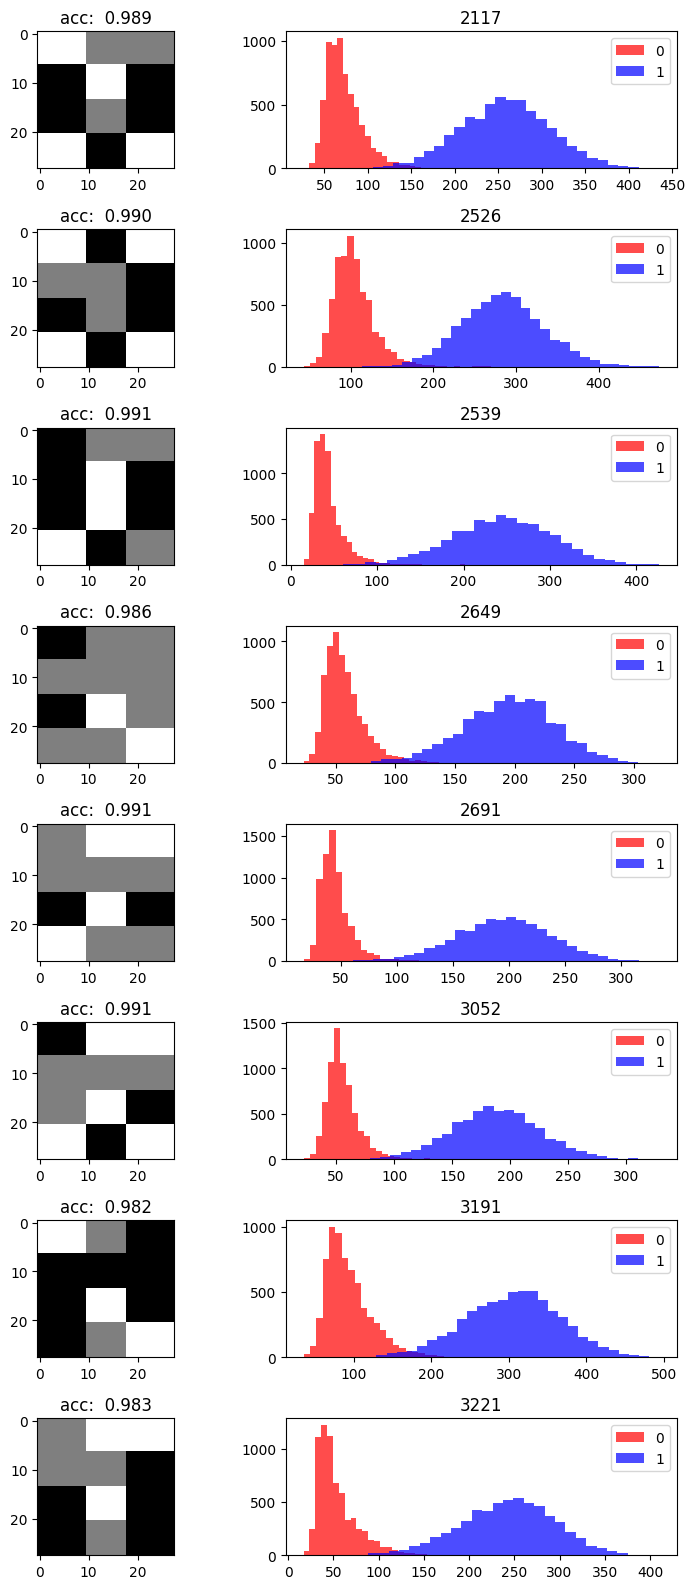

In [27]:

def compare_kernels(kernels, results=None):
    fig, axes = plt.subplots(len(kernels), 2, figsize=(8,16))
    titles = results if results is not None else ['']*len(kernels)
    for k, _axes, title in zip(kernels, axes, titles):
        im = _axes[0].imshow(k, cmap="binary")
        grid_search_result = grid_search_binary_classifier(k, image_data, label_data, labels=[1,0], n=64)
        _axes[0].set_title(f'acc: {grid_search_result.best_accuracy:6.3f}')
        # _overlap_score = overlap_score(np.expand_dims(k,0), image_data, label_data, [1,0]).item()
        # _axes[0].set_title(f'{_overlap_score}')
        f0 = (image_data[label_data == 1].clip(min=0, max=1) * k.reshape(1, 28, 28)).sum(axis=(1, 2))
        f1 = (image_data[label_data == 0].clip(min=0, max=1) * k.reshape(1, 28, 28)).sum(axis=(1, 2))
        bins = 30
        alpha = 0.7
        _axes[1].hist(f0, bins=bins, alpha=alpha, color="red", label="0")
        _axes[1].hist(f1, bins=bins, alpha=alpha, color="blue", label="1")
        _axes[1].set_title(title)
        _axes[1].legend()

    fig.tight_layout()

    # plt.colorbar(im, fig)
    return fig, axes


def compare_kernel_results(index):
    coefficients = kernel_results[index, :-1]
    kernels = model.linear_basis_kernel.get_kernels(model.linear_basis_kernel.basis, coefficients)
    return compare_kernels(kernels, kernel_results[index, -1])

# compare_kernel_results(rng.integers(0,len(kernel_results), 4))
# best_kernel_results_args = np.argsort(grid_search_results[:,-1])[:4]
compare_kernel_results(list(range(0,8)))


## Review

### Basic Workflow Steps:

1. Gather / Read Data
    * Boring
    * Difficult
    * Important
2. Data Analysis
    * Look at the data!
3. Data Preprocessing
    * Remove unnecessary information
    * Prepare derived information
4. Model Construction
    * Design a means of prediction (model)
    * Tune your model (optimization)
5. Model Evaluation
    * Understand your metrics
    * Tune your model (optimization)

**Step 1** is done and not interesting for us.

You will probably cycle through **Steps 2-5**, not necessarily in order.